# SENTENCE PAIRS CLASSIFICATION: GLOVE IMPLEMENTATION

### 1. DATA EXPLORATION

In [1]:
import numpy as np
import pandas as pd
import csv
import random

# Import packages for pre-processing
import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Cosine Similarity 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

# Data Modelling
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Load the SNLI dataset
path = '/Users/sergiogarcia/Documents/Thesis/Project/snli_1.0/'
train_data = pd.read_csv(path + 'snli_1.0_train.txt', sep="\t")
train_data = pd.DataFrame(train_data, columns=['sentence1', 'sentence2', 'gold_label'])

# Remove all the rows labeled as '-' and NaN values
train_data = train_data.loc[train_data['gold_label'] != '-']
train_data = train_data.dropna()

# Create a subset of the data in order to run de model faster
train_data = train_data.iloc[:10000,:]
train_data.head()

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [3]:
# Test set
test_data = pd.read_csv(path + 'snli_1.0_test.txt', sep="\t")
test_data = pd.DataFrame(test_data, columns=['sentence1', 'sentence2', 'gold_label'])

# Remove all the rows labeled as '-' and NaN values
test_data = test_data.loc[test_data['gold_label'] != '-']
test_data = test_data.dropna()

# Create a subset of the data in order to run de model faster
test_data = test_data.iloc[:2500,:]
test_data.head()

,sentence1,sentence2,gold_label
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral
1,This church choir sings to the masses as they ...,The church is filled with song.,entailment
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment


In [4]:
# Shuffle data
train_data = train_data.sample(frac=1, random_state=203)

# Size of the datasets 
print('Train Data size:', train_data.shape)
print('Test Data size:', test_data.shape)

Train Data size: (10000, 3)
Test Data size: (2500, 3)


In [5]:
# Labels distributions
print('==Labels train set:==\n{}'.format(train_data['gold_label'].value_counts()))
print('\n==Labels test set:==\n{}'.format(test_data['gold_label'].value_counts()))

==Labels train set:==
entailment       3340
contradiction    3334
neutral          3326
Name: gold_label, dtype: int64

==Labels test set:==
entailment       854
neutral          830
contradiction    816
Name: gold_label, dtype: int64


### 2. DATA PRE-PROCESSING

In [17]:
lemmat = WordNetLemmatizer()

def clean_text(sentence, lemma=False):    

    # Step 1: Transform text to lower case, remove url, some punctuations and long repeated characters 
    sent = sentence.lower()
    sent = re.sub(r'(http:)\S+', r'', sent)
    sent = re.sub(r'[\.,`=_/#]', r' ', sent)
    sent = re.sub(r'(\w)\1{2,}', r'\1\1', sent)

    # Step 2: Find the tokens of each text and apply lemmatization
    tokens = word_tokenize(sent)
    if lemma: tokens = [lemmat.lemmatize(w) for w in tokens] 

    return ' '.join(tokens)

# Data Cleaning in both sets
train_data['clean_sent1'] = train_data['sentence1'].map(lambda x: clean_text(x, lemma=True))
train_data['clean_sent2'] = train_data['sentence2'].map(lambda x: clean_text(x, lemma=True))


test_data['clean_sent1'] = test_data['sentence1'].map(lambda x: clean_text(x, lemma=True))
test_data['clean_sent2'] = test_data['sentence2'].map(lambda x: clean_text(x, lemma=True))

In [18]:
# Column with integer labels
dict_label = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
train_data['int_label'] = train_data['gold_label'].map(lambda x: dict_label[x])
test_data['int_label'] = test_data['gold_label'].map(lambda x: dict_label[x])

In [19]:
# Preview results after pre-processing
train_data.iloc[:3]

,sentence1,sentence2,gold_label,clean_sent1,clean_sent2,int_label,dist_cos,dist_euc
4638,Two small children playing football in yellow ...,two small children are playing football for th...,neutral,two small child playing football in yellow and...,two small child are playing football for their...,1,0.464148,1.035231
3472,Two asian females go walking.,The females are moving their legs.,entailment,two asian female go walking,the female are moving their leg,0,0.387333,1.106948
8723,A girl walking near a guy holding onto a bike ...,Two kids are riding mopeds.,contradiction,a girl walking near a guy holding onto a bike ...,two kid are riding moped,2,0.000000,1.414214


### 3. TEXT VECTORIZATION

In [20]:
max_features = 300

# Fit the vectorizer to the pair of training data and transform it separetely
vectorizer = TfidfVectorizer(max_features = max_features, max_df = 0.5)

# Join pair of sentences
pair_train = [' '.join([s1,s2]) for s1,s2 in train_data[['clean_sent1', 'clean_sent2']].values]
train_vec = vectorizer.fit(pair_train)

In [21]:
# Transform sentence independently
X_train1 = train_vec.transform(train_data['clean_sent1'].values)
X_train2 = train_vec.transform(train_data['clean_sent2'].values)

#Vectorize test sentences
X_test1 = train_vec.transform(test_data['clean_sent1'].values)
X_test2 = train_vec.transform(test_data['clean_sent2'].values)

print(X_train1.shape)
print(X_train2.shape)

(10000, 300)
(10000, 300)


### 4. SENTENCE SIMILARITY

In [22]:
# Create a Dictionary of labels with its cosine values
def dic_labels(x,y):
    
    dic = {
    'neutral': [],
    'entailment': [],
    'contradiction': []
    }
    
    for i,j in zip(x,y):
        if j == 'entailment':
            dic[j].append(i)
        elif j == 'neutral':
            dic[j].append(i)
        else:
            dic[j].append(i)
    
    return dic

In [23]:
# Compute distance metrics
cosine = lambda x,y: cosine_similarity(x.reshape(1,-1), y.reshape(1,-1)).flatten()[0]
euclidean = lambda x,y: euclidean_distances(x.reshape(1,-1), y.reshape(1,-1)).flatten()[0]

train_data['dist_cos'] = list(map(cosine, X_train1, X_train2))
train_data['dist_euc'] = list(map(euclidean, X_train1, X_train2))

dist_cos = dic_labels(train_data['dist_cos'].values, train_data['gold_label'].values)
dist_euc = dic_labels(train_data['dist_euc'].values, train_data['gold_label'].values)

In [24]:
train_data.iloc[:5]

,sentence1,sentence2,gold_label,clean_sent1,clean_sent2,int_label,dist_cos,dist_euc
4638,Two small children playing football in yellow ...,two small children are playing football for th...,neutral,two small child playing football in yellow and...,two small child are playing football for their...,1,0.464148,1.035231
3472,Two asian females go walking.,The females are moving their legs.,entailment,two asian female go walking,the female are moving their leg,0,0.387333,1.106948
8723,A girl walking near a guy holding onto a bike ...,Two kids are riding mopeds.,contradiction,a girl walking near a guy holding onto a bike ...,two kid are riding moped,2,0.000000,1.414214
341,A man squatting in the foreground of a photogr...,A male skateboarder performs tricks outdoors f...,neutral,a man squatting in the foreground of a photogr...,a male skateboarder performs trick outdoors fo...,1,0.176306,1.283506
703,A man carrying a load of fresh direct boxes on...,A young lad delivers groceries by bicycle in t...,contradiction,a man carrying a load of fresh direct box on c...,a young lad delivers grocery by bicycle in the...,2,0.206059,1.260112


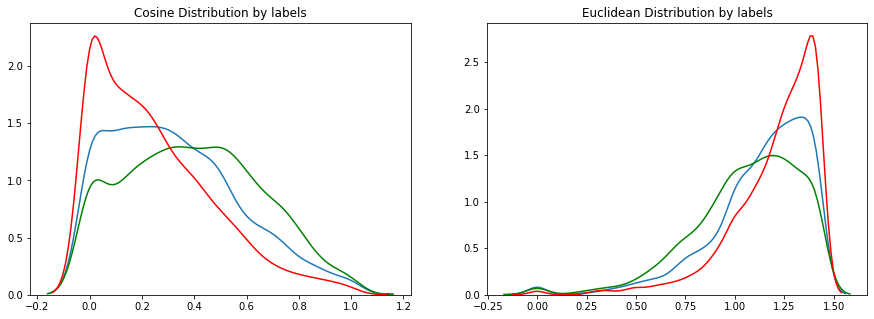

In [25]:
# Cosine scores distribution by labels
metric = ['Cosine', 'Euclidean']
results = [dist_cos, dist_euc]
fig, ax = plt.subplots(1,2, figsize=(15,5))

for i in range(0,2):
    sb.distplot(results[i]['neutral'], hist=False, ax=ax[i])
    sb.distplot(results[i]['entailment'], hist=False, color='green', ax=ax[i])
    sb.distplot(results[i]['contradiction'], hist=False, color='red', ax=ax[i])
    ax[i].set_title(metric[i] + ' Distribution by labels')

plt.show()


## 5. DATA MODELING. MULTI-CLASSIFICATION PROBLEM

In [29]:
# Transform saprse matrix to numpy
X_train1 = X_train1.todense().A
X_train2 = X_train2.todense().A

X_test1 = X_test1.todense().A
X_test2 = X_test2.todense().A

# The approach used to represent the input is going to be substraction (A sent_vector - B sent_vector)

X_train = []
N,_ = X_train1.shape
M,_ = X_test1.shape

for i in range(0,N):
    subs = X_train1[i] - X_train2[i]
    X_train.append(subs)
print('X_train Length:', len(X_train))
    
X_test = []
for i in range(0,M):
    subs = X_test1[i] - X_test2[i]
    X_test.append(subs)


y_train = np.array(train_data['int_label'].values)
y_test = np.array(test_data['int_label'].values)
print('y_train Shape:', y_train.shape)

X_train Length: 10000
y_train Shape: (10000,)


In [30]:
class EstimatorSelectionHelper:
    
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys() # list of models' names
        self.grid_searches = {} ## empty dictionary for the Grid.fit of each model
    
    def fit(self, X, y, **grid_kwargs):
        for key in self.keys:
            print('Running GridSearchCV for %s.' % key)
            model = self.models[key]
            params = self.params[key]
            grid_search = GridSearchCV(model, params, **grid_kwargs, cv=3)
            grid_search.fit(X, y)
            self.grid_searches[key] = grid_search ## fitting output from gird_search
        print('Done.')
    
    def score_summary(self, sort_by='mean_test_score'):
        frames = []
        for name, grid_search in self.grid_searches.items():
            frame = pd.DataFrame(grid_search.cv_results_) # The results for every combination of param
            frame = frame.filter(regex='^(?!.*param_).*$') # remove columns about GRID parameters
            frame['estimator'] = len(frame)*[name] # add the name of the model for every combo 
            frames.append(frame)
        df = pd.concat(frames) # final dict of all the training that the grid model has done
        
        df = df.sort_values([sort_by], ascending=False)
        df = df.reset_index()
        df = df.drop(['rank_test_score', 'index'], 1)
        
        # Reorder the columns so estimator is the first one
        columns = df.columns.tolist() 
        columns.remove('estimator') 
        columns = ['estimator']+columns 
        df = df[columns]
        return df

In [31]:
models = {
    'LogisticRegression': LogisticRegression(n_jobs=-1),
    'kNN': KNeighborsClassifier(n_jobs=-1),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1)
}

params = {
    'LogisticRegression': {'solver' : ['newton-cg', 'saga', 'sag'],
                          'C' : np.logspace(-10, 0, 10)
                          },
    'kNN': {'n_neighbors' : [3, 5, 10],
           'weights': ["uniform", "distance"]
           },
    'SVC': {'C': [0.1, 1, 10],
              'gamma': ['auto', 'scale']
           },
    'RandomForestClassifier': {'n_estimators': [10,50,100],
              'criterion': ['gini', 'entropy']
            }
}

In [32]:
t0 = time.time()

combined_results=pd.DataFrame()

helper = EstimatorSelectionHelper(models, params)

helper.fit(X_train, y_train, scoring='accuracy')
results = helper.score_summary()
combined_results = pd.concat([combined_results, results], ignore_index=True)

print('Time in minutes:', (time.time() - t0)/60)

Running GridSearchCV for LogisticRegression.
Running GridSearchCV for kNN.
Running GridSearchCV for SVC.
Running GridSearchCV for RandomForestClassifier.
Done.
Time in minutes: 13.570047148068745


In [33]:
# Display the results dataframe
results = results.sort_values(by='mean_test_score', ascending=False)
results = results.reset_index(drop=True)
cols = ['estimator', 'params', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
results = results[cols]
results.head(10)

,estimator,params,mean_test_score,mean_fit_time,mean_score_time
0,SVC,"{'C': 1, 'gamma': 'scale'}",0.527200,22.737381,8.293610
1,RandomForestClassifier,"{'criterion': 'entropy', 'n_estimators': 100}",0.494999,2.266024,0.114120
2,RandomForestClassifier,"{'criterion': 'gini', 'n_estimators': 100}",0.494900,1.820281,0.117069
3,SVC,"{'C': 10, 'gamma': 'auto'}",0.493000,24.374123,8.559503
4,RandomForestClassifier,"{'criterion': 'gini', 'n_estimators': 50}",0.492800,0.903558,0.113419
5,RandomForestClassifier,"{'criterion': 'entropy', 'n_estimators': 50}",0.492499,1.107773,0.112321
6,SVC,"{'C': 10, 'gamma': 'scale'}",0.489300,26.397822,8.569494
7,LogisticRegression,"{'C': 0.07742636826811278, 'solver': 'sag'}",0.487700,0.813487,0.003720
8,LogisticRegression,"{'C': 0.07742636826811278, 'solver': 'saga'}",0.487600,0.828690,0.003738
9,LogisticRegression,"{'C': 0.07742636826811278, 'solver': 'newton-cg'}",0.487600,0.634055,0.003629


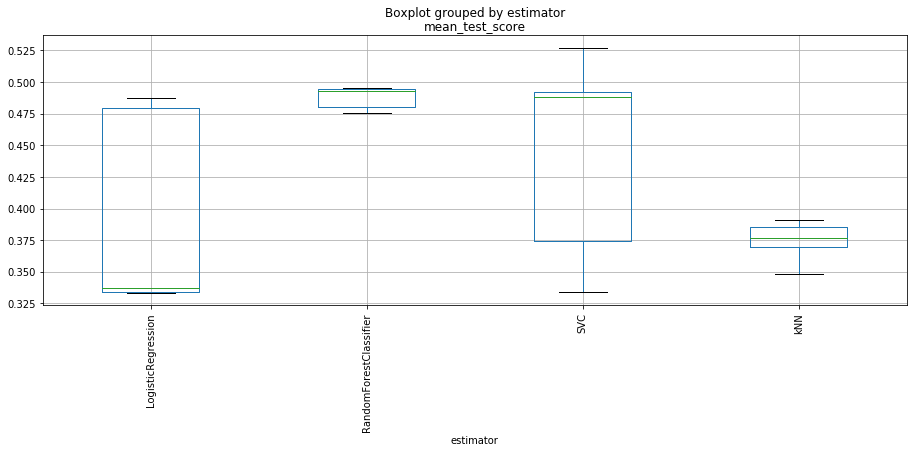

In [34]:
results.boxplot(column='mean_test_score',by='estimator', figsize=(15,5), rot=90)

### 6. ERROR ANALYSIS AND TEST RESULTS

In [35]:
# Predictions for the test set
param = results.loc[0, 'params']
top_model = SVC(**param)
top_model.fit(X_train,y_train)
y_pred = top_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.70      0.63       854
           1       0.57      0.48      0.52       830
           2       0.58      0.56      0.57       816

    accuracy                           0.58      2500
   macro avg       0.58      0.58      0.57      2500
weighted avg       0.58      0.58      0.57      2500



In [36]:
# Label the predictions with their correct name
labels_name = {0:'entailment', 1:'neutral', 2:'contradiction'}
label_pred = [labels_name[i] for i in y_pred] 

# Create a big data frame with the true labels and their predictions
final_df = test_data[['sentence1', 'sentence2', 'gold_label']]
final_df['predictions'] = label_pred 
final_df.head(9)

,sentence1,sentence2,gold_label,predictions
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral,entailment
1,This church choir sings to the masses as they ...,The church is filled with song.,entailment,contradiction
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction,contradiction
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral,neutral
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment,entailment
5,"A woman with a green headscarf, blue shirt and...",The woman has been shot.,contradiction,entailment
6,An old man with a package poses in front of an...,A man poses in front of an ad.,entailment,entailment
7,An old man with a package poses in front of an...,A man poses in front of an ad for beer.,neutral,neutral
8,An old man with a package poses in front of an...,A man walks by an ad.,contradiction,entailment


In [37]:
# Confusion Matrix
from sklearn import metrics

print('Confusion Matrix:')
metrics.confusion_matrix(y_test, y_pred) # Rows = true_labels and Col = predictions

Confusion Matrix:


array([[596, 130, 128],
       [241, 395, 194],
       [199, 164, 453]])

In [38]:
# Compare svm accuracy to the baseline method ('majority class')
baseline_acc = 854/2500
diff = 0.58/baseline_acc
print('Improvement of SVM: ',round(diff,2))

Improvement of SVM:  1.7
